# Credit Card Approval
This chapter explains the development of a custom deep learning model aimed at optimizing credit decisions for a financial institution. The primary objective of this model is to predict credit-related outcomes like approval status, credit limit, interest rate, and default risk. Furthermore, we aim to maximize profits while managing risks. This requires careful design of a custom loss function that balances profitability and credit risk.

Let’s break down the process.

## Understanding the Problem
**Business Objectives**

The institution wants to:

1. **Approve credit for customers**: Decide which customers should receive credit.
2. **Set credit limits**: Decide the maximum amount of credit for approved customers.
3. **Assign interest rates**: Set a suitable interest rate based on the customer’s risk profile.
4. **Predict default risks**: Estimate the probability that a customer might default on their credit.
5. **Optimize profits**: Use the model to maximize profit by accurately predicting the right credit terms and avoiding high-risk customers.
The institution profits by charging interest on approved credit, but it incurs losses when customers default on their payments. Therefore, optimizing profits requires balancing between generating interest (revenue) and avoiding defaults (costs).

The institution profits by charging interest on approved credit, but it incurs losses when customers default on their payments. Therefore, optimizing profits requires balancing between generating interest (revenue) and avoiding defaults (costs).

## Data Simulation
We created synthetic data to simulate customer behavior and credit-related factors. The dataset includes variables such as whether the customer was approved for credit, the credit limit they received, the interest rate applied, whether they defaulted, and the utilization rate (the proportion of the credit limit that the customer uses).

Here’s a look at the data preparation:

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Set the seed for reproducibility
np.random.seed(42)

# Generating synthetic data
num_samples = 1000
X = np.random.rand(num_samples, 2)  # Customer features (e.g., telecom data, demographics)
y_approved = np.random.randint(0, 2, size=(num_samples, 1))  # Approval status
y_credit_limit = np.random.rand(num_samples, 1) * (100000 - 10000) + 10000  # Credit limit between 10,000 to 100,000
y_interest_rate = np.random.rand(num_samples, 1) * (0.60 - 0.22) + 0.22  # Interest rate from 22% to 60%
y_defaulted = np.random.randint(0, 2, size=(num_samples, 1))  # Default status (0 or 1)
y_repayment = 1 - y_defaulted  # Repayment probability (inverse of default)
y_utilization_rate = np.random.rand(num_samples, 1)  # Credit utilization rate (0 to 1)

# Profit calculation based on observed data (for approved customers)
y_profit = y_approved * ((y_credit_limit * y_interest_rate * y_utilization_rate * y_repayment) - (y_credit_limit * y_defaulted))

observed = pd.DataFrame({
    'Approved': y_approved.flatten(),
    'Credit_Limit': y_credit_limit.flatten(),
    'Interest_Rate': y_interest_rate.flatten(),
    'Defaulted': y_defaulted.flatten(),
    'Repayment_Prob': y_repayment.flatten(),
    'Utilization_Rate': y_utilization_rate.flatten(), 
    'Profit': y_profit.flatten()
})

# Scale the input data for better convergence
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

**Key Variables**

 - Customer features (X): These are random values representing two customer characteristics (such as demographics or telecom data).
 - `y_approved`: Binary variable (0 or 1) indicating whether the customer was approved for credit.
 - `y_credit_limit`: The amount of credit granted to the customer, ranging between 10,000 and 100,000.
 - `y_interest_rate`: The interest rate charged to the customer, which ranges from 22% to 60%.
 - `y_defaulted`: Binary variable (0 or 1) indicating whether the customer defaulted on their credit.
 - `y_repayment`: The repayment probability, calculated as the inverse of the default status (i.e., 1 - y_defaulted).
 - `y_utilization_rate`: A random number between 0 and 1, representing the proportion of the credit limit that the customer actually uses.

**Profit Calculation**

Profit is calculated only for customers who were approved for credit. It is computed as:

$$
Profit=Credit Limit×Interest Rate×Utilization Rate×Repayment Probability−Credit Limit×Defaulted
$$

This equation reflects that profit depends on:

- How much of the credit limit is utilized by the customer (utilization rate).
- The interest charged on that utilization.
- The repayment probability (since profit is lost if the customer defaults).

## Model Architecture

### Input and Shared Layers
We start by defining the input features and creating a series of shared layers. These shared layers extract common representations from the customer data (like customer demographics, spending patterns, etc.) before making predictions.

In [2]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout

input_layer = Input(shape=(X_scaled.shape[1],))  # Input for customer features
shared = Dense(64, activation='relu', kernel_initializer='he_normal')(input_layer)
# Regularization to Prevent Overfitting
# Dropout Layers
# Dropout is a regularization technique that randomly drops neurons during training to make the model more robust.
# shared = Dropout(0.5)(shared)  # Drop 50% of the neurons during training
shared = Dense(32, activation='relu', kernel_initializer='he_normal')(shared)

- **Input layer**: Takes the customer features as input.
- **Shared layers**: Dense layers with ReLU activation, which allow the model to learn common patterns from the customer data before making predictions for the individual tasks.


### Output Layers for Different Predictions

We create specific output layers for each prediction task:

In [3]:
from tensorflow.keras.layers import Input, Dense, Concatenate

approval_output = Dense(1, activation='sigmoid', name='approved')(shared)  # Predict approval
credit_limit_output = Dense(1, activation='linear', name='creditlimit')(shared)  # Predict credit limit
interest_rate_output = Dense(1, activation='linear', name='interestrate')(shared)  # Predict interest rate
default_risk_output = Dense(1, activation='sigmoid', name='defaultrisk')(shared)  # Predict default risk
repayment_output = Dense(1, activation='sigmoid', name='repayment')(shared)  # Predict repayment probability
utilization_rate_output = Dense(1, activation='sigmoid', name='utilizationrate')(shared)  # Predict utilization rate

# Concatenate predicted outputs for custom loss
predicted_values_task1 = Concatenate()([approval_output, credit_limit_output, interest_rate_output, default_risk_output, repayment_output, utilization_rate_output])

- Approval prediction (`approval_output`): Uses a sigmoid activation because it’s a binary classification problem (approve or not).
- Credit limit prediction (`credit_limit_output`): Uses a linear activation because the credit limit is a continuous variable.
- Interest rate prediction (`interest_rate_output`): Similarly, uses linear activation for flexibility in predicting continuous values.
- Default risk prediction (`default_risk_output`) and repayment prediction (`repayment_output`): These use sigmoid activation since they are probabilities.
- Utilization rate prediction (`utilization_rate_output`): Predicts a value between 0 and 1, which is the proportion of the credit limit that the customer uses.

### Custom Loss Function for Profit Optimization

The core of this algorithm lies in optimizing profit while managing risk. We define a custom loss function that helps us maximize profit. This function factors in both the revenue (from interest) and the cost (from defaults). The overall goal is to maximize the difference between revenue and cost, which equates to maximizing profit.

#### Breakdown of the Loss Function

In [4]:
import tensorflow as tf

# User-defined parameters for constraints
lookahead_months = 6  # Example: looking ahead 6 months
days_in_lookahead = lookahead_months * 30  # Approximate number of days in the lookahead period
max_credit_limit = 100000  # Maximum credit limit
min_credit_limit = 10000  # Minimum credit limit
max_interest_rate = 0.6  # Maximum interest rate
min_interest_rate = 0.22 # Minimum interest rate 

def task1_custom_loss(y_true, y_pred):
    # Ground truth values
    true_approved = y_true[:, 0]  
    true_credit_limit = y_true[:, 1]  
    true_interest_rate = y_true[:, 2]  
    true_defaulted = y_true[:, 3]  
    true_repayment = y_true[:, 4]  
    true_utilization_rate = y_true[:, 5]  

    # Predictions
    pred_approval_prob = y_pred[:, 0]  
    pred_credit_limit = tf.minimum(tf.maximum(y_pred[:, 1], min_credit_limit), max_credit_limit)
    pred_interest_rate = tf.minimum(tf.maximum(y_pred[:, 2], min_interest_rate), max_interest_rate)
    pred_default_risk = y_pred[:, 3]
    pred_repayment = y_pred[:, 4]
    pred_utilization_rate = tf.clip_by_value(y_pred[:, 5], 0, 1)

    # Calculate Average Daily Balance (ADB)
    avg_daily_balance = pred_credit_limit * pred_utilization_rate

    # Calculate daily interest rate
    daily_interest_rate = pred_interest_rate / 365

    # Revenue is interest payments over the lookahead period
    interest = avg_daily_balance * daily_interest_rate * days_in_lookahead
    revenue = interest * pred_repayment  # Revenue from interest scaled by repayment probability

    # Cost from defaults
    cost = pred_credit_limit * pred_default_risk

    # Profit is calculated only for approved customers
    approved_numeric = tf.cast(pred_approval_prob >= 0.5, tf.float32)
    profit = approved_numeric * (revenue - cost)

    # We want to maximize profit, so return negative profit as loss
    return -tf.reduce_mean(profit)

#### Explanation

1. Predictions: The model predicts approval probability, credit limit, interest rate, default risk, repayment probability, and utilization rate. We ensure that the predicted values respect practical constraints (e.g., credit limits are within a predefined range).
2. Average Daily Balance (ADB): This is calculated by multiplying the predicted credit limit with the predicted utilization rate. It reflects the amount of credit that a customer uses on average daily.
3. Daily Interest Rate: The predicted interest rate is divided by 365 to convert it into a daily rate.
4. Revenue: The revenue is the interest earned on the ADB over a period of time (defined by `days_in_lookahead`), scaled by the predicted repayment probability.
5. Cost: The cost is the amount lost when a customer defaults, calculated as the credit limit multiplied by the predicted default risk.
6. Profit: Profit is the difference between revenue and cost, but we only consider it for approved customers (i.e., those with an approval probability above 0.5).
7. Loss: Since we want to maximize profit, we return the negative of the average profit as the loss function.

### Model Compilation and Training
We compile the model using the custom loss function, and then we train it on the scaled data.

In [5]:
model_task1 = Model(inputs=input_layer, outputs=predicted_values_task1)
model_task1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss=task1_custom_loss
)

# Prepare the training data
y_train = np.concatenate(
    [
        y_approved,
        y_credit_limit,
        y_interest_rate,
        y_defaulted,
        y_repayment,
        y_utilization_rate,
    ],
    axis=1,
)

# Train the model
history_task1 = model_task1.fit(
    X_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0
)


The training process optimizes the model parameters to maximize profit by balancing revenue generation and risk minimization.

## Model Evaluation
### Prediction and Counterfactual Analysis
Once the model is trained, we use it to make predictions for credit approval, credit limits, interest rates, and other variables. We can then calculate the predicted profit and compare it with the actual observed profit to evaluate the model's performance.

In [6]:
# Predictions
pred_task1 = model_task1.predict(X_scaled)

# Post-processing
pred_approval_prob = pred_task1[:, 0]
pred_approved = (pred_approval_prob >= 0.5).astype(int)
pred_credit_limit = np.minimum(np.maximum(pred_task1[:, 1], 0), max_credit_limit)
pred_interest_rate = np.minimum(np.maximum(pred_task1[:, 2], 0), max_interest_rate)
pred_default_risk = pred_task1[:, 3]
pred_repayment = pred_task1[:, 4]
pred_utilization_rate = np.clip(pred_task1[:, 5], 0, 1)

# Calculate predicted profit
avg_daily_balance = pred_credit_limit * pred_utilization_rate
daily_interest_rate = pred_interest_rate / 365
predicted_interest = avg_daily_balance * daily_interest_rate * days_in_lookahead
predicted_revenue = predicted_interest * pred_repayment
predicted_cost = pred_credit_limit * pred_default_risk
predicted_profit = (pred_approved * (predicted_revenue - predicted_cost)).flatten()

# Compare with actual profit
actual_profit = y_profit.flatten()
profit_diff = predicted_profit - actual_profit

# Display the results
pred_task1_df = pd.DataFrame({
    "approval prob": pred_approval_prob,
    "approved": pred_approved,
    "credit limit": pred_credit_limit,
    "interest rate": pred_interest_rate,
    "default risk": pred_default_risk,
    "repayment prob": pred_repayment,
    "utilization rate": pred_utilization_rate,
    "predicted profit": predicted_profit,
    "actual profit": actual_profit,
    "profit difference": profit_diff
})
# print(pred_task1_df.head(4))
print(f"Can make VND {sum(pred_task1_df['profit difference']):,.2f} more")

 1/32 [..............................] - ETA: 3s

32/32 [==============================] - 0s 1ms/step


Can make VND 10,231,358.18 more


### Credit Approval Prediction Evaluation
Credit approval is a binary classification task. Here, we’ll calculate metrics like accuracy, precision, recall, and the AUC-ROC.

Credit Approval Prediction - Evaluation Metrics:
Accuracy: 0.5110
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
AUC-ROC: 0.4702
Confusion Matrix:
[[511   0]
 [489   0]]


C:\ProgramData\anaconda3\envs\mlpy\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


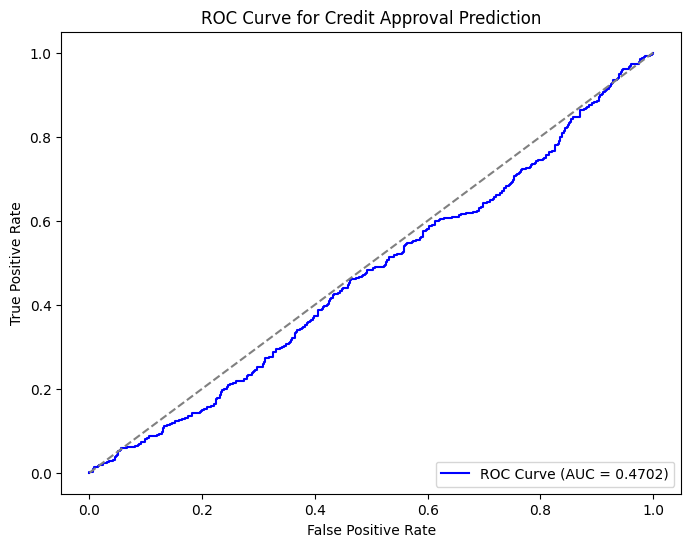

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Predicted and actual approval values
pred_approved = (pred_approval_prob >= 0.5).astype(int)  # Convert probabilities to binary approvals
actual_approved = y_approved.flatten()

# Calculate classification metrics
accuracy = accuracy_score(actual_approved, pred_approved)
precision = precision_score(actual_approved, pred_approved)
recall = recall_score(actual_approved, pred_approved)
f1 = f1_score(actual_approved, pred_approved)
roc_auc = roc_auc_score(actual_approved, pred_approval_prob)  # Use probabilities for AUC-ROC

# Confusion matrix
conf_matrix = confusion_matrix(actual_approved, pred_approved)

# Display the results
print(f"Credit Approval Prediction - Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")
print(f"Confusion Matrix:\n{conf_matrix}")

# Visualize the ROC Curve for Approval Prediction
# The ROC curve helps visualize the trade-off between the true positive rate and false positive rate at different thresholds.

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Calculate ROC curve
fpr, tpr, _ = roc_curve(actual_approved, pred_approval_prob)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC Curve for Credit Approval Prediction')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

### Credit Limit Prediction Evaluation
Credit limit is a continuous variable, so we'll use regression metrics like Mean Absolute Error (MAE), Mean Squared Error (MSE), and R-squared (R²) to evaluate the predictions.

Credit Limit Prediction - Evaluation Metrics:
MAE: 55126.36
MSE: 3716174896.90
R-squared: -4.4871


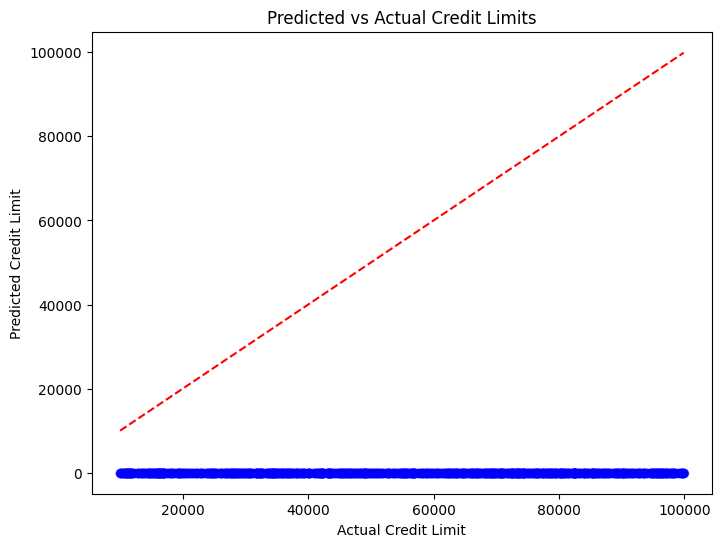

In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Predicted and actual credit limits
actual_credit_limit = y_credit_limit.flatten()

# Calculate regression metrics
mae_credit_limit = mean_absolute_error(actual_credit_limit, pred_credit_limit)
mse_credit_limit = mean_squared_error(actual_credit_limit, pred_credit_limit)
r2_credit_limit = r2_score(actual_credit_limit, pred_credit_limit)

# Display the results
print(f"Credit Limit Prediction - Evaluation Metrics:")
print(f"MAE: {mae_credit_limit:.2f}")
print(f"MSE: {mse_credit_limit:.2f}")
print(f"R-squared: {r2_credit_limit:.4f}")

# Visualize Credit Limit Predictions vs Actual Values
# It’s helpful to visualize how the predicted values compare to the actual credit limits. A scatter plot with a diagonal line (representing perfect prediction) can show how well the model performed.
plt.figure(figsize=(8, 6))
plt.scatter(actual_credit_limit, pred_credit_limit, color='blue', alpha=0.5)
plt.plot([min(actual_credit_limit), max(actual_credit_limit)], [min(actual_credit_limit), max(actual_credit_limit)], color='red', linestyle='--')
plt.title('Predicted vs Actual Credit Limits')
plt.xlabel('Actual Credit Limit')
plt.ylabel('Predicted Credit Limit')
plt.show()

### Interest Rate Prediction Evaluation
Interest rate is also a continuous prediction, so we'll use the same regression metrics as for credit limit (MAE, MSE, and R²).

Interest Rate Prediction - Evaluation Metrics:
MAE: 0.2266
MSE: 0.0703
R-squared: -4.9445


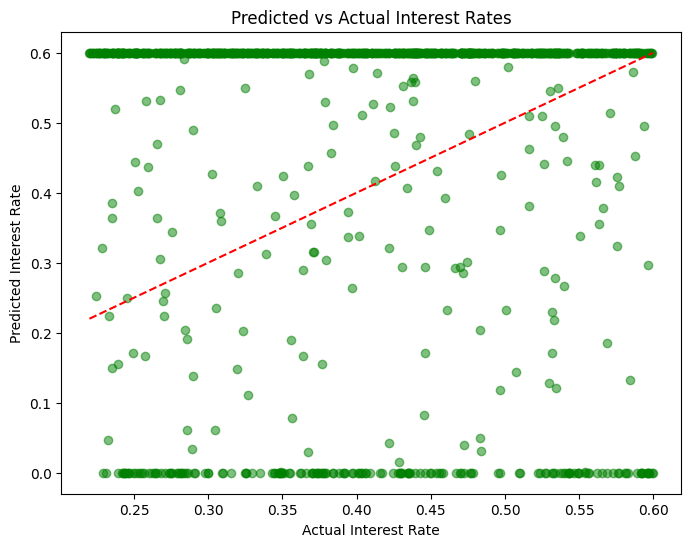

In [9]:
# Predicted and actual interest rates
actual_interest_rate = y_interest_rate.flatten()

# Calculate regression metrics for interest rate
mae_interest_rate = mean_absolute_error(actual_interest_rate, pred_interest_rate)
mse_interest_rate = mean_squared_error(actual_interest_rate, pred_interest_rate)
r2_interest_rate = r2_score(actual_interest_rate, pred_interest_rate)

# Display the results
print(f"Interest Rate Prediction - Evaluation Metrics:")
print(f"MAE: {mae_interest_rate:.4f}")
print(f"MSE: {mse_interest_rate:.4f}")
print(f"R-squared: {r2_interest_rate:.4f}")


plt.figure(figsize=(8, 6))
plt.scatter(actual_interest_rate, pred_interest_rate, color='green', alpha=0.5)
plt.plot([min(actual_interest_rate), max(actual_interest_rate)], [min(actual_interest_rate), max(actual_interest_rate)], color='red', linestyle='--')
plt.title('Predicted vs Actual Interest Rates')
plt.xlabel('Actual Interest Rate')
plt.ylabel('Predicted Interest Rate')
plt.show()

### Default Risk Prediction Evaluation
Default risk prediction is a classification task. We can evaluate it using the same metrics as for credit approval: accuracy, precision, recall, F1-score, and AUC-ROC.

Default Risk Prediction - Evaluation Metrics:
Accuracy: 0.4970
Precision: 0.5014
Recall: 0.7347
F1-Score: 0.5960
AUC-ROC: 0.4940


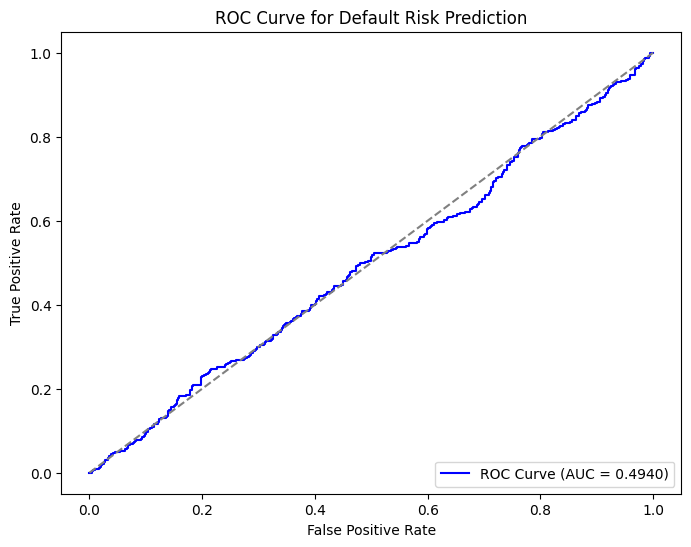

In [10]:
# Predicted and actual default risk values
actual_default_risk = y_defaulted.flatten()

# Calculate classification metrics for default risk
accuracy_default = accuracy_score(actual_default_risk, (pred_default_risk >= 0.5).astype(int))
precision_default = precision_score(actual_default_risk, (pred_default_risk >= 0.5).astype(int))
recall_default = recall_score(actual_default_risk, (pred_default_risk >= 0.5).astype(int))
f1_default = f1_score(actual_default_risk, (pred_default_risk >= 0.5).astype(int))
roc_auc_default = roc_auc_score(actual_default_risk, pred_default_risk)

# Display the results
print(f"Default Risk Prediction - Evaluation Metrics:")
print(f"Accuracy: {accuracy_default:.4f}")
print(f"Precision: {precision_default:.4f}")
print(f"Recall: {recall_default:.4f}")
print(f"F1-Score: {f1_default:.4f}")
print(f"AUC-ROC: {roc_auc_default:.4f}")

# Calculate ROC curve for default risk
fpr_default, tpr_default, _ = roc_curve(actual_default_risk, pred_default_risk)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_default, tpr_default, color='blue', label=f'ROC Curve (AUC = {roc_auc_default:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC Curve for Default Risk Prediction')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

### Profit Evaluation
Finally, the primary business objective is to maximize profit, so evaluating how well the model predicts profits is crucial.

We can compare the predicted profit with the actual profit using metrics like MAE, MSE, and R². Additionally, visualizing the predicted and actual profits can give further insights.

Profit Prediction - Evaluation Metrics:
MAE: 15558.13
MSE: 912406517.33
R-squared: -0.1296


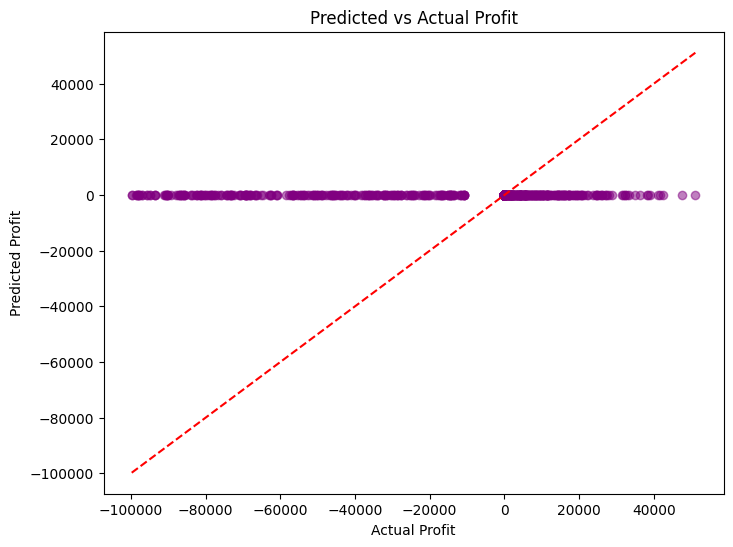

In [11]:
# Actual profit
actual_profit = y_profit.flatten()

# Calculate regression metrics for profit
mae_profit = mean_absolute_error(actual_profit, predicted_profit)
mse_profit = mean_squared_error(actual_profit, predicted_profit)
r2_profit = r2_score(actual_profit, predicted_profit)

# Display the results
print(f"Profit Prediction - Evaluation Metrics:")
print(f"MAE: {mae_profit:.2f}")
print(f"MSE: {mse_profit:.2f}")
print(f"R-squared: {r2_profit:.4f}")

plt.figure(figsize=(8, 6))
plt.scatter(actual_profit, predicted_profit, color='purple', alpha=0.5)
plt.plot([min(actual_profit), max(actual_profit)], [min(actual_profit), max(actual_profit)], color='red', linestyle='--')
plt.title('Predicted vs Actual Profit')
plt.xlabel('Actual Profit')
plt.ylabel('Predicted Profit')
plt.show()

### Out-of-Sample Testing (Holdout Set or Deployment)
```
# Assuming X_test and y_test are your holdout test sets
test_predictions = model_task1.predict(X_test)

# Evaluate the model on the test set
test_mse = mean_squared_error(y_test, test_predictions)
print(f"Test MSE: {test_mse:.2f}")
```


Other considerations include:
- Cross-validation: Ensures model performance is not overly optimistic and generalizes well.
- Hyperparameter tuning: Finds the best configuration for your model to improve its predictive accuracy.
- Feature importance: Helps identify which features drive the model’s predictions, improving explainability and interpretability.
- Handling Class Imbalance
- Regularization: Reduces overfitting and improves generalization to unseen data.
- Explainability: Provides transparency, which is especially important in regulatory environments.
- Counterfactual Analysis
- Profit strategies: Ensures that business objectives (like profit maximization) are being met by the model.